In [1]:
from pathlib import Path
import torch
import pytorch_lightning as pl
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from umap import UMAP
from sklearn.manifold import TSNE
from unsupervised_meta_learning.callbacks.pcacallbacks import *
from unsupervised_meta_learning.callbacks.umapcallbacks import *
from unsupervised_meta_learning.pl_dataloaders import (
    UnlabelledDataModule, get_episode_loader
)
from torch.utils.data import DataLoader
from unsupervised_meta_learning.protoclr import ProtoCLR, get_prototypes, prototypical_loss
from unsupervised_meta_learning.dataclasses.protoclr_container import (
    PCLRParamsContainer, ReRankerContainer,
)
from torchmeta.datasets.helpers import miniimagenet
from torchmeta.utils.data import BatchMetaDataLoader, MetaDataLoader
from unsupervised_meta_learning.proto_utils import CNN_4Layer

pl.seed_everything(42)
sns.set(rc={'figure.figsize':(10, 10)})

%matplotlib inline
%reload_ext autoreload
%autoreload 2

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Global seed set to 42


## ProtoCLR-C Loading

In [2]:
dataset = 'miniimagenet'
datapath = './data/untarred'
lr = 1e-3
inner_lr = 1e-3
gamma = 1.0
distance = "euclidean"
ckpt_dir = Path("./ckpts")
ae = False
tau = 1.0
eval_ways = 5
clustering_alg = 'hdbscan'
clustering_callback = False
km_clusters = 25
km_use_nearest = True
km_n_neighbours = 50
cl_reduction = 'mean'
eval_support_shots = 5
eval_query_shots = 15
n_images = None
n_classes = 10
n_support = 1
n_query = 3
batch_size = 100
no_aug_support = True
no_aug_query = False
logging = "wandb"
log_images = False
profiler = "torch"
train_oracle_mode = True
train_oracle_ways = None
train_oracle_shots = None
num_workers = 3
callbacks = True
patience = 200
use_plotly = True
use_umap = False
umap_min_dist: float = .25
rdim_n_neighbors: int = 50
rdim_components: int = 2
rerank_kjrd = False
rrk1 = 20
rrk2 = 6
rrlambda = 0
uuid = None

In [3]:
params = PCLRParamsContainer(
    dataset,
    datapath,
    seed=42,
    gpus=1,
    lr=lr,
    inner_lr=inner_lr,
    gamma=gamma,
    distance=distance,
    ckpt_dir=Path("./ckpts"),
    ae=ae,
    tau=tau,
    clustering_algo=clustering_alg,
    km_clusters=km_clusters,
    km_use_nearest=km_use_nearest,
    km_n_neighbours=km_n_neighbours,
    cl_reduction=cl_reduction,
    eval_ways=eval_ways,
    eval_support_shots=eval_support_shots,
    eval_query_shots=eval_query_shots,
    n_images=n_images,
    n_classes=n_classes,
    n_support=n_support,
    n_query=n_query,
    batch_size=batch_size,
    no_aug_support=no_aug_support,
    no_aug_query=no_aug_query,
    log_images=log_images,
    train_oracle_mode=train_oracle_mode,
    train_oracle_ways=train_oracle_ways,
    train_oracle_shots=train_oracle_shots,
    num_workers=num_workers,
    use_umap=use_umap,
    umap_min_dist=umap_min_dist,
    rdim_components=int(rdim_components),
    rdim_n_neighbors=int(rdim_n_neighbors),
    rerank_kjrd=rerank_kjrd,
    re_rank_args=ReRankerContainer(k1=rrk1, k2=rrk2, lambda_value=rrlambda),
    sup_finetune=False,
    mode='testing'
)

In [4]:
# model = ProtoCLR.load_from_checkpoint("./data/volcanic-field-114/epoch=297-step=29799-loss_epoch=0.44-train_accuracy_epoch=0.906.ckpt", params=params)
model = ProtoCLR.load_from_checkpoint(
    "./data/run_ckpts/warding-totem-46/epoch=144-step=14499-val_loss=1.17-val_accuracy=0.597.ckpt", params=params)

Clustering algo in use: hdbscan


In [5]:
model.sup_finetune

False

In [6]:
def data_reshaper(xs, n_support, n_query):
    data = xs["data"]
    # e.g. 50 images, 2 support, 2 query, miniImageNet: torch.Size([1, 50, 4, 3, 84, 84])
    data = data.unsqueeze(0)
    batch_size = data.size(0)
    ways = data.size(1)

    # Divide into support and query shots
    x_support = data[:, :, : n_support]
    # e.g. [1,50*n_support,*(3,84,84)]
    x_support = x_support.reshape(
        (batch_size, ways * n_support, *x_support.shape[-3:])
    )
    x_query = data[:, :, n_support:]
    # e.g. [1,50*n_query,*(3,84,84)]
    x_query = x_query.reshape(
        (batch_size, ways * n_query, *x_query.shape[-3:])
    )

    # Create dummy query labels
    y_query = torch.arange(ways).unsqueeze(0).unsqueeze(2)  # batch and shot dim
    y_query = y_query.repeat(batch_size, 1, n_query)
    y_query = y_query.view(batch_size, -1).type_as(data).long()

    y_support = torch.arange(ways).unsqueeze(0).unsqueeze(2)  # batch and shot dim
    y_support = y_support.repeat(batch_size, 1, n_support)
    y_support = y_support.view(batch_size, -1).type_as(data).long()

    x = torch.cat([x_support, x_query], 1)

    return x, y_support, y_query

In [7]:
udm = UnlabelledDataModule(params)
udm.setup()
dl = udm.train_dataloader()

In [8]:
xs = next(iter(dl))

In [9]:
x, y_s, y_q = data_reshaper(xs, 1, 3)

In [10]:
labels = xs['labels']

In [12]:
y_s = labels[:, 0].cpu()
y_q = labels[:, 1:].flatten().cpu()
lb_enc = LabelEncoder()
lb_enc.fit(y_s)
y_s = torch.Tensor(lb_enc.transform(y_s)).type_as(labels)
y_q = torch.Tensor(lb_enc.transform(y_q)).type_as(labels)

In [13]:
y = torch.cat([y_s, y_q]).squeeze(0)

In [14]:
model = model.to('cuda')

In [15]:
z, _ = model(x.cuda())

In [16]:
zu = UMAP(n_components=2).fit_transform(z.squeeze(0).detach().cpu().numpy())

<AxesSubplot:>

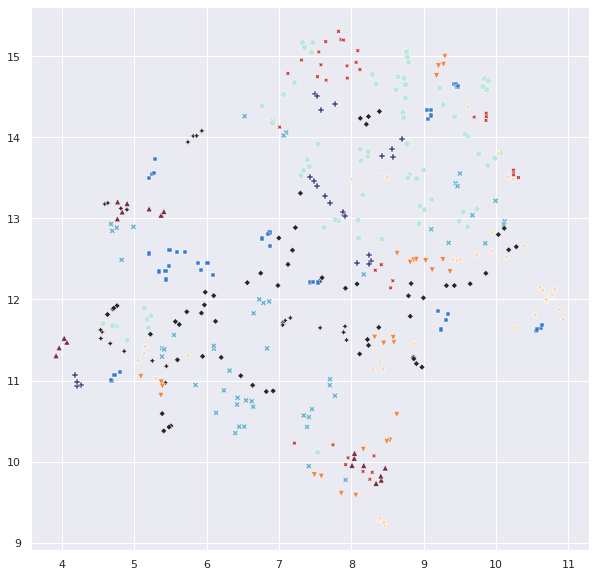

In [17]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.scatterplot(x=zu[:, 0], y=zu[:, 1], hue=y, palette="icefire", style=y, legend=False)

In [18]:
zt = TSNE(n_components=2).fit_transform(z.squeeze(0).detach().cpu().numpy())

<AxesSubplot:>

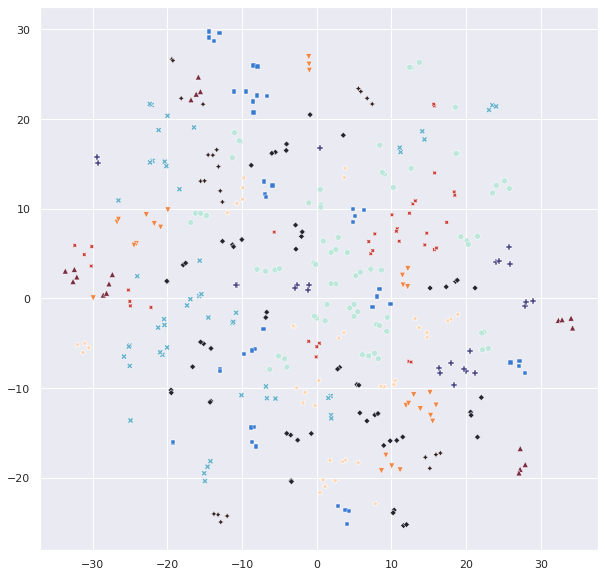

In [19]:
sns.scatterplot(x=zt[:, 0], y=zt[:, 1], hue=y, palette="icefire", style=y, legend=False)

## Oracle Mode model

In [24]:
model = ProtoCLR.load_from_checkpoint(
    "./data/protoclr-c-mini-oracle/epoch=191-step=19199-loss_epoch=5.42-train_accuracy_epoch=0.183.ckpt", params=params)

Clustering algo in use: hdbscan


In [25]:
model = model.to('cuda')

In [26]:
z, _ = model(x.cuda())

In [27]:
torch.cuda.empty_cache()

In [28]:
zu = UMAP(n_components=2).fit_transform(z.squeeze(0).detach().cpu().numpy())

<AxesSubplot:>

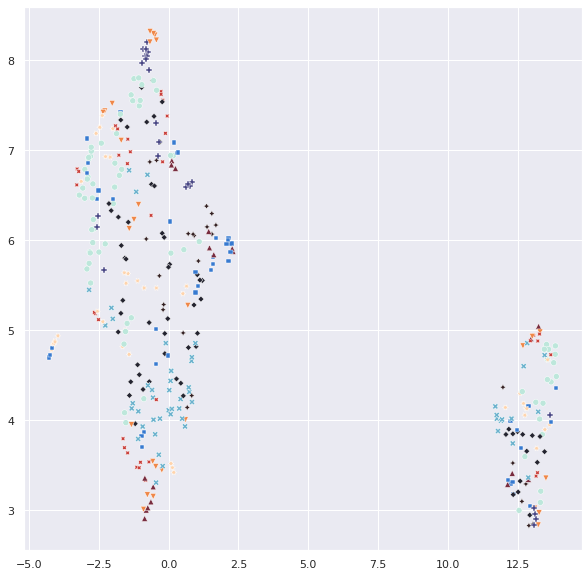

In [29]:
sns.scatterplot(x=zu[:, 0], y=zu[:, 1], hue=y, palette="icefire", style=y, legend=False)

In [30]:
zt = TSNE(n_components=2, ).fit_transform(z.squeeze(0).detach().cpu().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

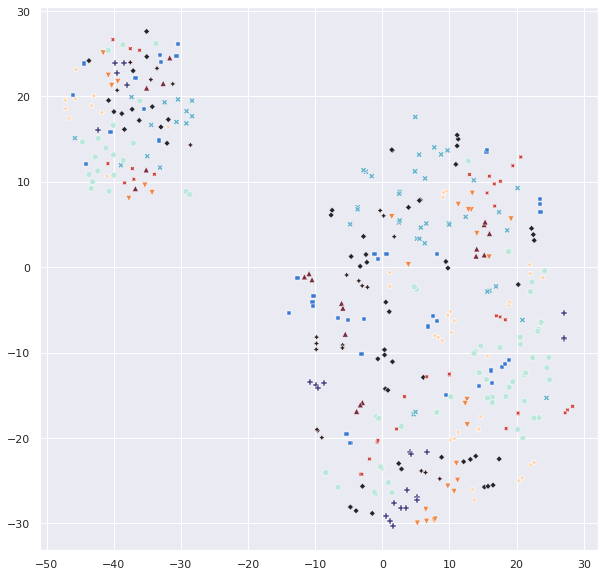

In [31]:
sns.scatterplot(x=zt[:, 0], y=zt[:, 1], hue=y, palette="icefire", style=y, legend=False)

In [32]:
y.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([72, 52, 44, 24, 60, 24, 20, 36, 28, 40]))

## Vanilla ProtoCLR Loading

In [20]:
import torch.nn as nn


class Protonet(nn.Module):
    """Prototypical network

    Parameters:
    - encoder (nn.Module): Embedding function.
    - distance (string): Use euclidean or cosine distance.
    - device (string, torch.device): Use GPU or CPU?
    
    """

    def __init__(self, encoder, distance='euclidean', device="cpu"):
        super(Protonet, self).__init__()
        self.encoder = encoder
        self.device = device
        self.distance = distance

    def loss(self, sample, ways):
        # Extract support and query data
        # with shape [batch_size x num_samples x img_dims]
        # Labels are dummy labels in [0, ..., ways]
        if "support" in sample.keys():
            x_support = sample["support"][0]
            y_support = sample["support"][1]
        else:
            x_support = sample["train"][0]
            y_support = sample["train"][1]
        x_support = x_support.to(self.device)
        y_support = y_support.to(self.device)

        if "query" in sample.keys():
            x_query = sample["query"][0]
            y_query = sample["query"][1]
        else:
            x_query = sample["test"][0]
            y_query = sample["test"][1]
        x_query = x_query.to(self.device)
        y_query = y_query.to(self.device)

        # Extract shots
        shots = int(x_support.size(1) / ways)
        test_shots = int(x_query.size(1) / ways)

        # Extract features (first dim is batch dim)
        x = torch.cat([x_support, x_query], 1)
        z = self.encoder.forward(x)
        z_support = z[:, :ways * shots]
        z_query = z[:, ways * shots:]

        # Calucalte prototypes
        z_proto = get_prototypes(z_support, y_support, ways)

        # Calculate loss and accuracies
        loss, accuracy = prototypical_loss(z_proto, z_query, y_query,
                                           distance=self.distance)

        return loss, accuracy

In [21]:
encoder = CNN_4Layer(in_channels=3)

In [22]:
proto = Protonet(encoder, distance='euclidean', device=torch.device('cpu'))

In [30]:
ckpt = torch.load("../ProtoTransfer/vanilla/ckpt_200_best.pth.tar",
                  map_location=torch.device('cpu'))

In [31]:
proto.encoder.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [ ]:
z = proto.encoder.forward(x)

In [26]:
zu = UMAP(n_components=2).fit_transform(z.squeeze(0).detach().numpy())

<AxesSubplot:>

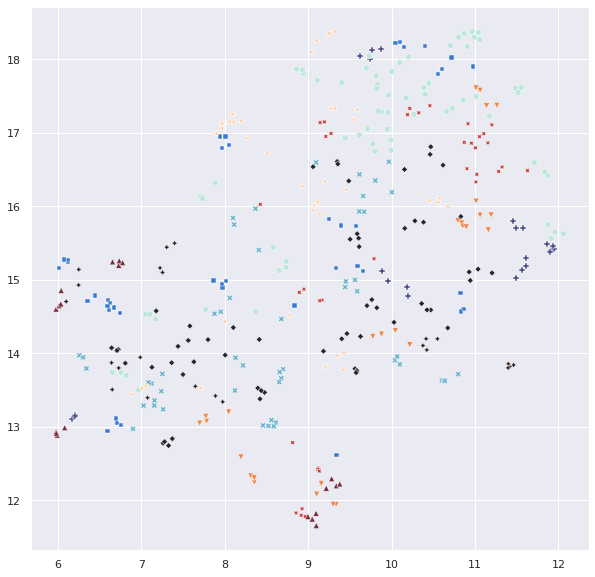

In [27]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.scatterplot(x=zu[:, 0], y=zu[:, 1], hue=y, palette="icefire", style=y, legend=False)

In [28]:
zt = TSNE(n_components=2).fit_transform(z.squeeze(0).detach().numpy())

<AxesSubplot:>

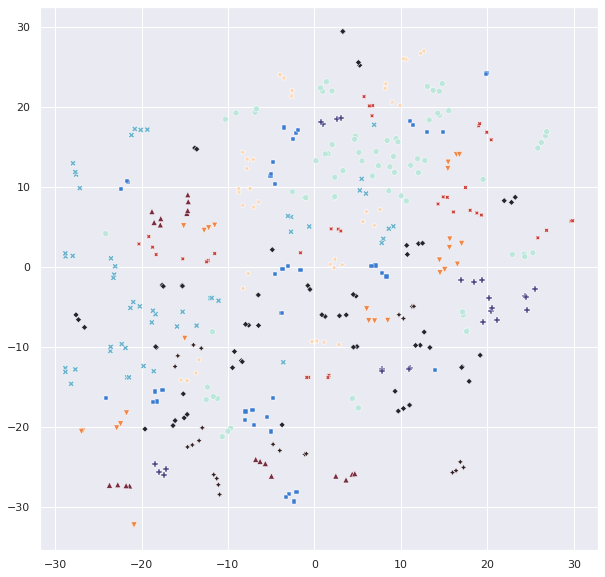

In [29]:
sns.scatterplot(x=zt[:, 0], y=zt[:, 1], hue=y, palette="icefire", style=y, legend=False,)

In [16]:
del proto

In [17]:
del zu

In [18]:
import gc

gc.collect()

8302